In [1]:
Yijia Lu
5/22/2023

https://github.com/TClyj/EE-machine-learning-project.git
    

The following example code and data is from https://github.com/Jan-Williams/pyshred

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [2]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

We now select indices to divide the data into training, validation, and test sets.

In [3]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [4]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

We train the model using the training and validation datasets.

In [6]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=500, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.4752)
Training epoch 20
Error tensor(0.2213)
Training epoch 40
Error tensor(0.2150)
Training epoch 60
Error tensor(0.2170)
Training epoch 80
Error tensor(0.2128)
Training epoch 100
Error tensor(0.2103)
Training epoch 120
Error tensor(0.2048)
Training epoch 140
Error tensor(0.1967)
Training epoch 160
Error tensor(0.1792)
Training epoch 180
Error tensor(0.1710)
Training epoch 200
Error tensor(0.1607)
Training epoch 220
Error tensor(0.1533)
Training epoch 240
Error tensor(0.1488)
Training epoch 260
Error tensor(0.1397)
Training epoch 280
Error tensor(0.1335)
Training epoch 300
Error tensor(0.1287)
Training epoch 320
Error tensor(0.1250)
Training epoch 340
Error tensor(0.1230)
Training epoch 360
Error tensor(0.1220)
Training epoch 380
Error tensor(0.1184)
Training epoch 400
Error tensor(0.1177)
Training epoch 420
Error tensor(0.1170)
Training epoch 440
Error tensor(0.1164)
Training epoch 460
Error tensor(0.1158)
Training epoch 480
Error tensor(0.1144)
Traini

Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [7]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.021365903


In [8]:
# The following code is written by me in order to complete the required tasks for this homework

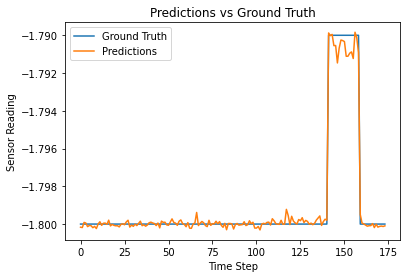

In [8]:
# Q2 plot the trained result.
import matplotlib.pyplot as plt

# Choose a random sensor to plot
sensor_index = 0

# Plot the ground truth values
plt.plot(test_ground_truth[:, sensor_index], label='Ground Truth')

# Plot the predicted values
plt.plot(test_recons[:, sensor_index], label='Predictions')

plt.title('Predictions vs Ground Truth')
plt.xlabel('Time Step')
plt.ylabel('Sensor Reading')

plt.legend()
plt.show()

Training epoch 1
Error tensor(0.4796)
Training epoch 20
Error tensor(0.2232)
Training epoch 40
Error tensor(0.2153)
Training epoch 60
Error tensor(0.2139)
Training epoch 1
Error tensor(0.4736)
Training epoch 20
Error tensor(0.2218)
Training epoch 40
Error tensor(0.2146)
Training epoch 60
Error tensor(0.2182)
Training epoch 1
Error tensor(0.4741)
Training epoch 20
Error tensor(0.2192)
Training epoch 40
Error tensor(0.2149)
Training epoch 60
Error tensor(0.2151)
Training epoch 1
Error tensor(0.4735)
Training epoch 20
Error tensor(0.2203)
Training epoch 40
Error tensor(0.2167)
Training epoch 60
Error tensor(0.2163)


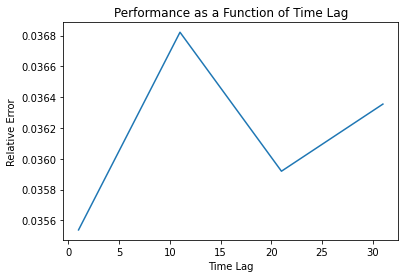

In [11]:
# Question 3
import numpy as np

# Define the list of lag values to test
lags = np.arange(1, 41, 10)

# Prepare a list to store the performance metrics for each lag value
performance_metrics = []

for lag in lags:
    # Redefine your datasets using the current lag value
    # You will need to adapt this to your specific code
    all_data_in = np.zeros((n - lag, lag, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lag, sensor_locations]
    
    # Create the model and train it on the training data
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=60, lr=1e-3, verbose=True, patience=5)
    
    # Evaluate the model on the test data
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    
    # Store the performance metric
    performance_metrics.append(error)

# Plot the performance metrics as a function of the lag value
plt.plot(lags, performance_metrics)
plt.title('Performance as a Function of Time Lag')
plt.xlabel('Time Lag')
plt.ylabel('Relative Error')
plt.show()

Training epoch 1
Error tensor(0.4732)
Training epoch 20
Error tensor(0.2190)
Training epoch 40
Error tensor(0.2147)
Training epoch 60
Error tensor(0.2158)
Training epoch 1
Error tensor(0.4737)
Training epoch 20
Error tensor(0.2203)
Training epoch 40
Error tensor(0.2149)
Training epoch 60
Error tensor(0.2137)
Training epoch 1
Error tensor(0.4726)
Training epoch 20
Error tensor(0.2199)
Training epoch 40
Error tensor(0.2153)
Training epoch 60
Error tensor(0.2183)
Training epoch 1
Error tensor(0.4844)
Training epoch 20
Error tensor(0.2230)
Training epoch 40
Error tensor(0.2166)
Training epoch 60
Error tensor(0.2152)
Training epoch 1
Error tensor(0.4808)
Training epoch 20
Error tensor(0.2182)
Training epoch 40
Error tensor(0.2165)
Training epoch 60
Error tensor(0.2136)
Training epoch 1
Error tensor(0.4771)
Training epoch 20
Error tensor(0.2231)
Training epoch 40
Error tensor(0.2150)
Training epoch 60
Error tensor(0.2142)


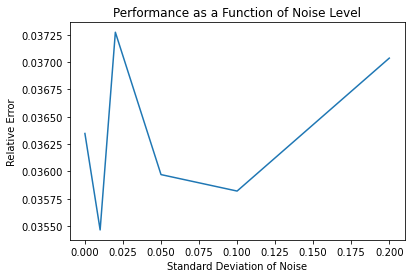

In [14]:
# Question 4
import numpy as np

# Define the list of standard deviations for the Gaussian noise
std_devs = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2]

lags = 52

# Prepare a list to store the performance metrics for each level of noise
performance_metrics = []

for std_dev in std_devs:
    # Add Gaussian noise to the data
    noisy_X = load_X + np.random.normal(scale=std_dev, size=load_X.shape)
    
    # Preprocess the noisy data
    sc = MinMaxScaler()
    sc = sc.fit(noisy_X[train_indices])
    transformed_X = sc.transform(noisy_X)

    # Redefine your datasets using the noisy data
    # You will need to adapt this to your specific code
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]
    
    # and so on for the rest of your dataset creation code...
    
    # Create the model and train it on the noisy data
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=60, lr=1e-3, verbose=True, patience=5)
    
    # Evaluate the model on the test data
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    
    # Store the performance metric
    performance_metrics.append(error)

# Plot the performance metrics as a function of the standard deviation of the noise
plt.plot(std_devs, performance_metrics)
plt.title('Performance as a Function of Noise Level')
plt.xlabel('Standard Deviation of Noise')
plt.ylabel('Relative Error')
plt.show()


Training epoch 1
Error tensor(0.4682)
Training epoch 20
Error tensor(0.2475)
Training epoch 40
Error tensor(0.2350)
Training epoch 60
Error tensor(0.2263)
Training epoch 1
Error tensor(0.4828)
Training epoch 20
Error tensor(0.2278)
Training epoch 40
Error tensor(0.2189)
Training epoch 60
Error tensor(0.2178)
Training epoch 1
Error tensor(0.4691)
Training epoch 20
Error tensor(0.2334)
Training epoch 40
Error tensor(0.2205)
Training epoch 60
Error tensor(0.2163)
Training epoch 1
Error tensor(0.4811)
Training epoch 20
Error tensor(0.2399)
Training epoch 40
Error tensor(0.2313)
Training epoch 60
Error tensor(0.2251)
Training epoch 1
Error tensor(0.4799)
Training epoch 20
Error tensor(0.2182)
Training epoch 40
Error tensor(0.2132)
Training epoch 60
Error tensor(0.2092)
Training epoch 1
Error tensor(0.4734)
Training epoch 20
Error tensor(0.2228)
Training epoch 40
Error tensor(0.2148)
Training epoch 60
Error tensor(0.2047)


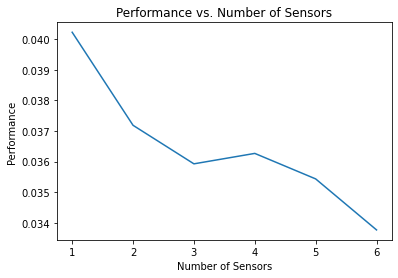

In [16]:
# Question 5
def analyze_performance(num_sensors):
    lags = 52
    load_X = load_data('SST')
    n = load_X.shape[0]
    m = load_X.shape[1]
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]

    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=60, lr=1e-3, verbose=True, patience=5)

    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    performance = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)

    return performance

# Define the range of number of sensors to analyze
num_sensors_range = range(1, 7)  # Example: 1 to 7 sensors

performance_results = []
for num_sensors in num_sensors_range:
    performance = analyze_performance(num_sensors)
    performance_results.append(performance)

# Plot the performance results
plt.plot(num_sensors_range, performance_results)
plt.xlabel('Number of Sensors')
plt.ylabel('Performance')
plt.title('Performance vs. Number of Sensors')
plt.show()